In [1]:
import os
import os.path as op
import numpy as np
import re
import itertools
from typing import Tuple, Iterator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from scipy.stats import ttest_1samp
# from util.io.coherence import *

In [11]:
# Load data

df = pd.DataFrame()
root = Path('../data/bids/derivatives/abr/')
for file in root.rglob("*"):
    if '.pkl' not in file.name:
        continue
    print(file)
    sub_df = pd.read_pickle(file)
    df = df.append(sub_df)
df = df.reset_index()
df

../data/bids/derivatives/abr/sub-29_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-41_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-24_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-14_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-11_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-25_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-39_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-4_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-31_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-35_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-8_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-43_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-40_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-9_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-30_task-dichotic_run-1_abr.pkl
../data/bids/derivatives/abr/sub-5_task-dic

/tmp/ipykernel_24711/2068530568.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sub_df)
/tmp/ipykernel_24711/2068530568.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sub_df)
/tmp/ipykernel_24711/2068530568.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sub_df)
/tmp/ipykernel_24711/2068530568.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sub_df)
/tmp/ipykernel_24711/2068530568.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sub_df)
/tmp/ipykernel_

,index,sub,task,run,tone_num,stream,attended,right_channels,x,y,dB_diff
0,0,29,dichotic,1,1,l,True,AF3,175,366,1.405150
1,1,29,dichotic,1,1,l,True,C1,182,245,6.168212
2,2,29,dichotic,1,1,l,True,C3,144,245,-4.302575
3,3,29,dichotic,1,1,l,True,C5,102,245,2.336631
4,4,29,dichotic,1,1,l,True,T7,63,245,5.849975
...,...,...,...,...,...,...,...,...,...,...,...
6463,319,33,dichotic,1,3,r,False,P7,95,150,4.158728
6464,320,33,dichotic,1,3,r,False,PO3,174,121,4.725843
6465,321,33,dichotic,1,3,r,False,PO7,130,114,1.300532
6466,322,33,dichotic,1,3,r,False,TP7,71,195,-1.756627


In [3]:
# Create Iterator over different conditions

tone_num_options = [1, 2, 3]
stream_options = ['l', 'r']
attended_options = [True, False]
subs = np.unique(df['sub']).tolist()

KeyType = Tuple[int, str, bool]

def iterConditions(tone_num_options, stream_options, attended_options, subs) -> Iterator[KeyType]:
    for tone_num in tone_num_options:
        for stream in stream_options:
            for attended in attended_options:
                for sub in subs:
                    key = (tone_num, stream, attended, sub)
                    yield key

In [4]:
# Get coordinates
coords = pd.read_csv('../data/captrak/2dcoords.csv')
coords

,Unnamed: 0,ch_name,x,y,y_new
0,0,Fp1,174,397,397
1,1,Fz,224,325,325
2,2,F3,156,328,328
3,3,F7,94,339,339
4,4,FT9,32,306,306
...,...,...,...,...,...
57,57,F6,324,331,331
58,58,AF4,273,366,366
59,59,F2,257,326,326
60,60,FCz,224,286,286


In [5]:
# Get coordinates of right channels
# Its right_channels - left_channels
# So plot right channels coords
x_coords = []
y_coords = []

for i, row in df.iterrows():
    right_channels = row['right_channels']
    row_x_coords = []
    row_y_coords = []
    for channel in right_channels:

        x_coord = coords['x'][coords['ch_name'] == channel]
        x_coord = x_coord.tolist()[0]
        row_x_coords.append(x_coord)
        y_coord = coords['y'][coords['ch_name'] == channel]
        y_coord = y_coord.tolist()[0]
        row_y_coords.append(y_coord)
    
    x_coords.append(row_x_coords)
    y_coords.append(row_y_coords)
        
df['x_coords'] = x_coords
df['y_coords'] = y_coords

In [17]:
df # originally 6468 rows

,index,sub,task,run,tone_num,stream,attended,right_channels,x,y,dB_diff,mean
0,0,29,dichotic,1,1,l,True,AF3,175,366,1.405150,0.136748
1,1,29,dichotic,1,1,l,True,C1,182,245,6.168212,0.136748
2,2,29,dichotic,1,1,l,True,C3,144,245,-4.302575,0.136748
3,3,29,dichotic,1,1,l,True,C5,102,245,2.336631,0.136748
4,4,29,dichotic,1,1,l,True,T7,63,245,5.849975,0.136748
...,...,...,...,...,...,...,...,...,...,...,...,...
6463,319,33,dichotic,1,3,r,False,P7,95,150,4.158728,0.057747
6464,320,33,dichotic,1,3,r,False,PO3,174,121,4.725843,0.057747
6465,321,33,dichotic,1,3,r,False,PO7,130,114,1.300532,0.057747
6466,322,33,dichotic,1,3,r,False,TP7,71,195,-1.756627,0.057747


In [20]:
df_means = df.groupby(['tone_num', 'stream', 'attended', 'right_channels'], sort=False)['dB_diff'].mean()
# df['mean'] = grp.transform('mean')
# df
# df['mean_avg'] = grp.rolling(2, min_periods=1).mean().values

In [21]:
df_means

tone_num  stream  attended  right_channels
1         l       True      AF3               0.309566
                            C1                0.136337
                            C3               -0.049295
                            C5                0.405126
                            T7               -0.067567
                                                ...   
3         r       False     P7                1.203248
                            PO3               0.014748
                            PO7              -0.988570
                            TP7               0.890918
                            TP9              -0.391579
Name: dB_diff, Length: 324, dtype: float64

(1, 'l', True, '11')
(1, 'l', True, '14')
(1, 'l', True, '24')
(1, 'l', True, '25')
(1, 'l', True, '29')
(1, 'l', True, '30')
(1, 'l', True, '31')
(1, 'l', True, '33')
(1, 'l', True, '35')
(1, 'l', True, '38')
(1, 'l', True, '39')


ValueError: Length of values (26) does not match length of index (27)

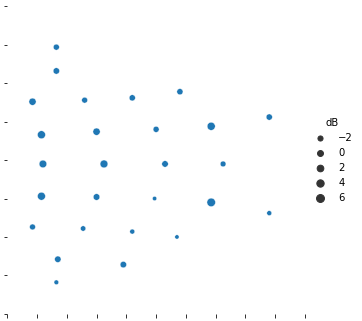

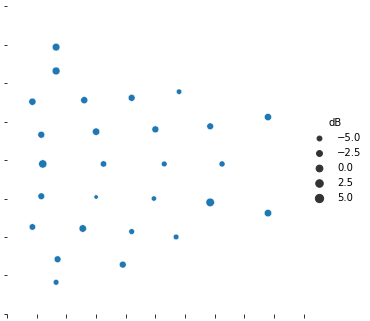

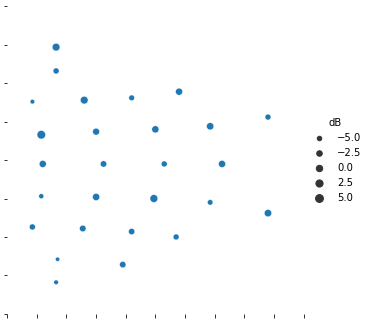

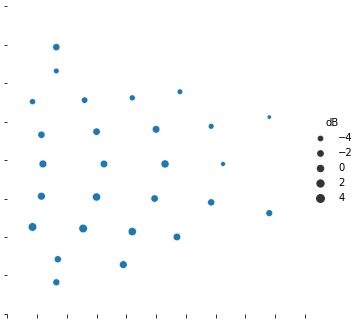

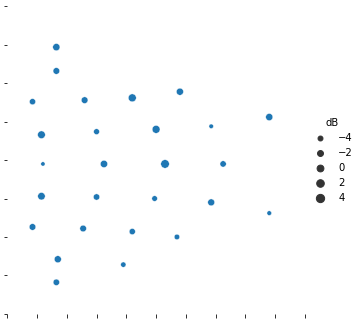

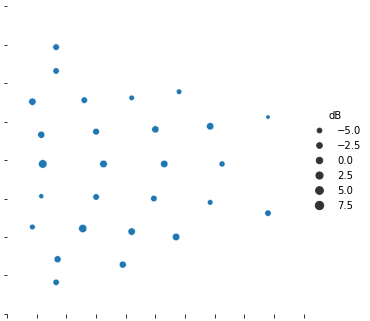

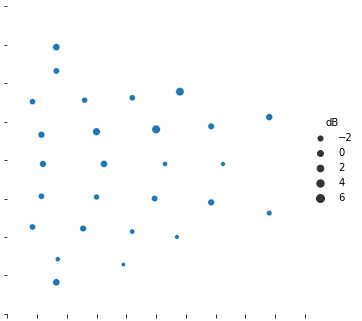

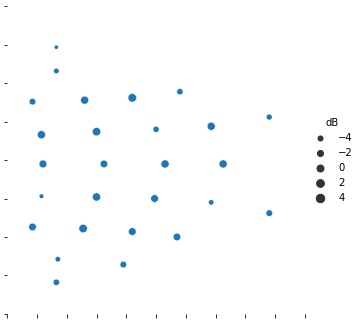

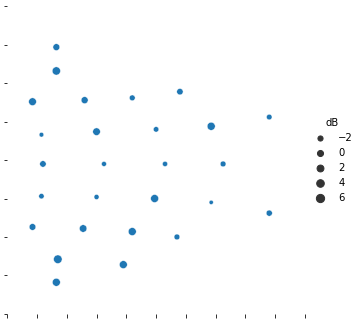

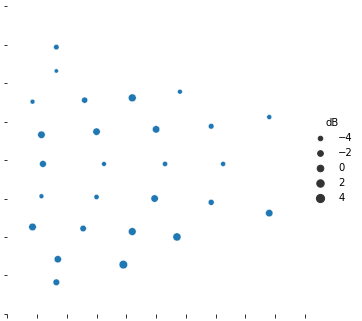

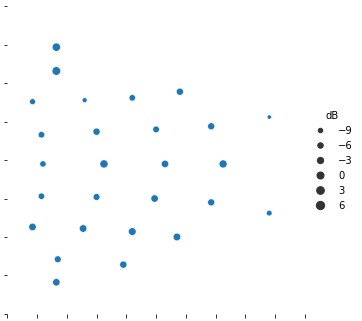

In [114]:
for condition in iterConditions(tone_num_options, stream_options, attended_options, subs):
    tone_num = condition[0]
    stream = condition[1]
    attended = condition[2]
    sub = condition[3]
    row = df[(df['tone_num'] == tone_num) & (df['stream'] == stream) & (df['attended'] == attended) & (df['sub'] == sub)]
    row = row.reset_index()
    dB_diff = row['dB_diff'][0]
    cond_dB_diff = dB_diff[tone_num - 1,:]
    samp_x_coords = row['x_coords'][0]
    samp_y_coords = row['y_coords'][0]
    plot_df = pd.DataFrame({'dB': cond_dB_diff, 'x': samp_x_coords, 'y': samp_y_coords}, index = range(0, 27))
    print(condition)
    plot_map(df)
#     break

In [113]:
def plot_map(df):
    ax = sns.relplot(x = "x", y = "y", size = "dB", data = plot_df)
    ax.despine(left = True, bottom = True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabels('')
    ax.set_ylabels('')


In [103]:
str(condition)

"(1, 'l', True, '4')"

In [90]:
plot_df

,dB,x,y
0,"[1.0746380940722005, 4.904560896351354, 5.5851...","0 [273, 264, 305, 346, 385, 263, 300, 339, ...","0 [366, 245, 245, 245, 245, 203, 202, 200, ..."


In [79]:
df[(df['tone_num'] == tone_num) & (df['stream'] == stream)]

,index,sub,task,run,tone_num,stream,attended,right_channels,left_channels,freqs,dB_diff
0,0,29,dichotic,1,1,l,True,"[AF4, C2, C4, C6, T8, CP2, CP4, CP6, F2, F4, F...","[AF3, C1, C3, C5, T7, CP1, CP3, CP5, F1, F3, F...","[102.4487756121939, 104.94752623688156, 107.44...","[[-0.5316632235315222, -5.100984206910201, 0.9..."
6,6,29,dichotic,1,1,l,False,"[AF4, C2, C4, C6, T8, CP2, CP4, CP6, F2, F4, F...","[AF3, C1, C3, C5, T7, CP1, CP3, CP5, F1, F3, F...","[102.4487756121939, 104.94752623688156, 107.44...","[[4.976057495763091, 1.8695265433272952, 7.846..."
12,0,41,dichotic,1,1,l,True,"[AF4, C2, C4, C6, T8, CP2, CP4, CP6, F2, F4, F...","[AF3, C1, C3, C5, T7, CP1, CP3, CP5, F1, F3, F...","[102.4487756121939, 104.94752623688156, 107.44...","[[3.0043628391951924, 3.839415106428545, 3.897..."
18,6,41,dichotic,1,1,l,False,"[AF4, C2, C4, C6, T8, CP2, CP4, CP6, F2, F4, F...","[AF3, C1, C3, C5, T7, CP1, CP3, CP5, F1, F3, F...","[102.4487756121939, 104.94752623688156, 107.44...","[[-1.6453717862740138, 6.472305057972314, 3.60..."
24,0,24,dichotic,1,1,l,True,"[AF4, C2, C4, C6, T8, CP2, CP4, CP6, F2, F4, F...","[AF3, C1, C3, C5, T7, CP1, CP3, CP5, F1, F3, F...","[102.4487756121939, 104.94752623688156, 107.44...","[[-1.2740321105262584, 1.9325065375549617, -0...."
30,6,24,dichotic,1,1,l,False,"[AF4, C2, C4, C6, T8, CP2, CP4, CP6, F2, F4, F...","[AF3, C1, C3, C5, T7, CP1, CP3, CP5, F1, F3, F...","[102.4487756121939, 104.94752623688156, 107.44...","[[0.78655363660366, 1.6275353477716616, 0.2535..."
36,0,14,dichotic,1,1,l,True,"[AF4, C2, C4, C6, T8, CP2, CP4, CP6, F2, F4, F...","[AF3, C1, C3, C5, T7, CP1, CP3, CP5, F1, F3, F...","[102.4487756121939, 104.94752623688156, 107.44...","[[3.460335659796801, 4.772792401669587, -1.564..."
42,6,14,dichotic,1,1,l,False,"[AF4, C2, C4, C6, T8, CP2, CP4, CP6, F2, F4, F...","[AF3, C1, C3, C5, T7, CP1, CP3, CP5, F1, F3, F...","[102.4487756121939, 104.94752623688156, 107.44...","[[3.7864583637928515, 0.7010484549018055, 1.93..."
48,0,11,dichotic,1,1,l,True,"[AF4, C2, C4, C6, T8, CP2, CP4, CP6, F2, F4, F...","[AF3, C1, C3, C5, T7, CP1, CP3, CP5, F1, F3, F...","[102.4487756121939, 104.94752623688156, 107.44...","[[1.0746380940722005, 4.904560896351354, 5.585..."
54,6,11,dichotic,1,1,l,False,"[AF4, C2, C4, C6, T8, CP2, CP4, CP6, F2, F4, F...","[AF3, C1, C3, C5, T7, CP1, CP3, CP5, F1, F3, F...","[102.4487756121939, 104.94752623688156, 107.44...","[[-0.47802400190047545, -2.4112300926145958, 0..."
